### Problem Statement:  HELP International, an international humanitarian NGO raised the funds and want to invest it for overall development of the countries that are in the direst need of aid. 
### we need to categorise the countries using some socio-economic and health factors that determine the overall development of the country.

### Approach:
1) EDA on the dataset. Read the data, find missing values and do the Outlier Analysis:

2) Perform PCA on the dataset and obtain the new dataset with the Principal Components. Choose the appropriate number of components k and perform the clustering activity on this new dataset, i.e. the PCA modified dataset with the k components

3) Try both K-means and Hierarchical clustering(both single and complete linkage) on this dataset to create the clusters.

4) Analyse the clusters and identify the ones which are in dire need of aid by comparing how these three variables - [gdpp, child_mort and income] vary for each cluster of countries to recognise and differentiate the clusters of developed countries from the clusters of under-developed countries.

5) perform visualisations on the clusters that have been formed.

6) The final list of countries depends on the number of components that are choosen and the number of clusters that are finally formed.

# Reading the Data

In [1557]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [1558]:
#import all the necessary libraries

import pandas as pd
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [1559]:
# Importing Housing.csv
country = pd.read_csv('Country-data.csv')

In [1560]:
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [1561]:
country.shape

(167, 10)

In [1562]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


## Converting the % columns exports/health/imports to reflect per Capita information

In [1563]:
# As gdpp is Total GDP/Total population means GDP per capita we can find exports/health/imports per capita as follows
country['exports'] = round((country['exports']*country['gdpp'])/100,2)
country['health'] = round((country['health']*country['gdpp'])/100,2)
country['imports'] = round((country['imports']*country['gdpp'])/100,2)

country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


## Check for null values

In [1564]:
# Step 1 : Check for Null Data
country.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [1565]:
# Step 2 : Check for duplicate rows
print(country.shape)
country.drop_duplicates(keep='first',inplace=True)
print(country.shape)
# As we can see number of rows and columns are still same. There are no duplicate present in the data

(167, 10)
(167, 10)


## Checking for outliers in the continuous variables

In [1566]:
#num_country = country[['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']]

# Checking outliers at 25%,50%,75%,90%,95% and 99%
country.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618862,1056.733174,6588.352096,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885789,1801.408921,14710.810423,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


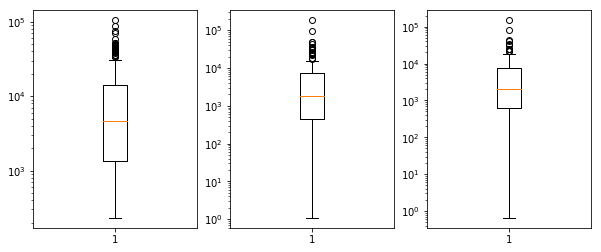

In [1567]:
plt.figure(figsize = (10,4)) 
plt.subplot(1,3,1)
plt.boxplot(country['gdpp'])   # original scale
plt.yscale('log')

plt.subplot(1,3,2)
plt.boxplot(country['exports'])   # original scale
plt.yscale('log')

plt.subplot(1,3,3)
plt.boxplot(country['imports'])   # original scale
plt.yscale('log')

plt.show()


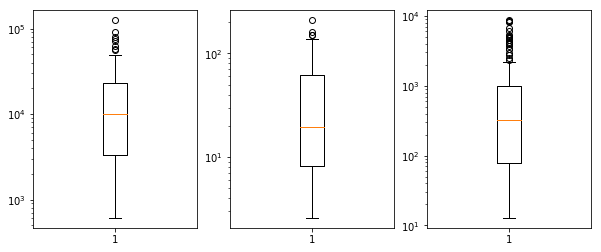

In [1568]:
plt.figure(figsize = (10,4)) 
plt.subplot(1,3,1)
plt.boxplot(country['income'])   # original scale
plt.yscale('log')

plt.subplot(1,3,2)
plt.boxplot(country['child_mort'])   # original scale
plt.yscale('log')

plt.subplot(1,3,3)
plt.boxplot(country['health'])   # original scale
plt.yscale('log')

plt.show()

In [1569]:
# As we can observe from the describe matrics, there are outliers(mean value is totally different from median) present in the data for below cloumns
# exports,health,imports,income
# two types of outliers:
# - statistical
# - domain specific

In [1570]:
# removing (statistical) outliers

# outlier treatment for exports
Q1 = country.child_mort.quantile(0.05)
Q3 = country.child_mort.quantile(0.95)
IQR = Q3 - Q1
country = country[(country.child_mort >= Q1 - 1.5*IQR) & (country.child_mort <= Q3 + 1.5*IQR)]
print(country.shape)


# outlier treatment for exports
Q1 = country.exports.quantile(0.05)
Q3 = country.exports.quantile(0.95)
IQR = Q3 - Q1
country = country[(country.exports >= Q1 - 1.5*IQR) & (country.exports <= Q3 + 1.5*IQR)]
print(country.shape)
# 2 rows removed based on export

# outlier treatment for health
Q1 = country.health.quantile(0.05)
Q3 = country.health.quantile(0.95)
IQR = Q3 - Q1
country = country[(country.health >= Q1 - 1.5*IQR) & (country.health <= Q3 + 1.5*IQR)]
print(country.shape)


# outlier treatment for imports
Q1 = country.imports.quantile(0.05)
Q3 = country.imports.quantile(0.95)
IQR = Q3 - Q1
country = country[(country.imports >= Q1 - 1.5*IQR) & (country.imports <= Q3 + 1.5*IQR)]
print(country.shape)


# outlier treatment for income
Q1 = country.income.quantile(0.05)
Q3 = country.income.quantile(0.95)
IQR = Q3 - Q1
country = country[(country.income >= Q1 - 1.5*IQR) & (country.income <= Q3 + 1.5*IQR)]
print(country.shape)
# 1 rows removed based on income

# outlier treatment for gdpp
Q1 = country.gdpp.quantile(0.05)
Q3 = country.gdpp.quantile(0.95)
IQR = Q3 - Q1
country = country[(country.gdpp >= Q1 - 1.5*IQR) & (country.gdpp <= Q3 + 1.5*IQR)]
print(country.shape)


#Luxembourg Singapore Qatar has been removed as part of outlier analysis based on High Export and Income

(167, 10)
(165, 10)
(165, 10)
(165, 10)
(164, 10)
(164, 10)


In [1571]:
# 3 rows are removed after outlier treatment from 167 to164
country.shape

(164, 10)

### 1. Principal Component Analysis

In [1572]:
# Putting feature variable to X
X = country[['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']]

# Putting response variable to y
y = country['country']

### 1.1 Data Scaling using standard scaler

In [1573]:
## First let us see if we can explain the dataset using fewer variables
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
country2 = standard_scaler.fit_transform(X)
scaled_df = country2

In [1574]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [1575]:
#Performing the PCA on Scaled data
pca.fit(country2)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [1576]:
#List of PCA components.
pca.components_

array([[-3.09694412e-01,  3.63807593e-01,  3.56805341e-01,
         3.69125069e-01,  3.75217860e-01, -1.38914652e-01,
         3.35854715e-01, -2.94122880e-01,  3.85717070e-01],
       [ 4.99243734e-01,  3.16856631e-01,  2.59282784e-01,
         2.70815668e-01,  1.36707072e-01,  2.27637805e-01,
        -3.68771642e-01,  4.91708503e-01,  2.48014741e-01],
       [-1.52857694e-01, -8.62401057e-03, -8.56254411e-02,
        -7.40309168e-02,  1.49701295e-01,  9.46341337e-01,
         1.97138838e-01, -8.30249828e-02, -4.31116224e-03],
       [ 2.91106416e-02, -4.98322045e-01,  6.06824430e-01,
        -4.59729431e-01,  1.18985538e-02,  8.77235934e-04,
         1.53508802e-01,  1.60084652e-01,  3.49150796e-01],
       [ 2.19505457e-01, -9.32385346e-02,  3.38996487e-02,
        -1.83739670e-01,  3.22203143e-01,  3.50662286e-02,
        -5.82544286e-01, -6.73417701e-01,  1.01590975e-01],
       [ 6.56018757e-03, -1.63756682e-02, -4.08216955e-01,
        -3.14332217e-01,  7.60945258e-01, -1.765077

In [1577]:
#Let's check the variance ratios
pca.explained_variance_ratio_

array([0.63814336, 0.16369442, 0.10001887, 0.03754607, 0.02540395,
       0.02259068, 0.00946654, 0.00186849, 0.00126763])

In [1578]:
# Check the cumulative value of variance
print (pca.explained_variance_ratio_.cumsum())

[0.63814336 0.80183778 0.90185664 0.93940271 0.96480666 0.98739734
 0.99686388 0.99873237 1.        ]


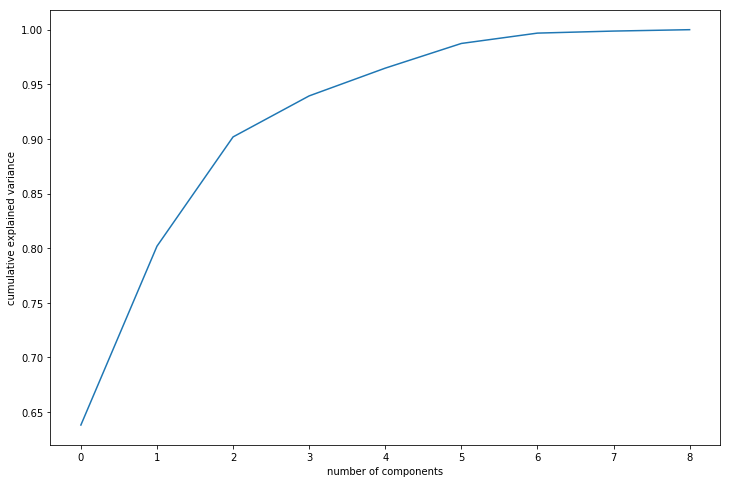

In [1579]:
#Plotting the scree plot
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### Around 96% of the variance in data is being explained by 5 components

In [1580]:
#Understanding how the original variables are loaded on the principal components. It can be verified from above as well.
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2],
                       'PC4':pca.components_[3],'PC5':pca.components_[4],
                       'PC6':pca.components_[5],'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'Feature':colnames})
pcs_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Feature
0,-0.309694,0.499244,-0.152858,0.029111,0.219505,0.006560,0.763095,0.009600,-0.000522,child_mort
1,0.363808,0.316857,-0.008624,-0.498322,-0.093239,-0.016376,-0.014402,-0.118276,-0.704051,exports
2,0.356805,0.259283,-0.085625,0.606824,0.033900,-0.408217,-0.077359,0.465326,-0.198977,health
3,0.369125,0.270816,-0.074031,-0.459729,-0.183740,-0.314332,0.029208,0.168807,0.641607,imports
4,0.375218,0.136707,0.149701,0.011899,0.322203,0.760945,-0.011101,0.344731,0.127103,income
5,-0.138915,0.227638,0.946341,0.000877,0.035066,-0.176508,-0.024321,-0.000839,0.018553,inflation
6,0.335855,-0.368772,0.197139,0.153509,-0.582544,0.117997,0.577626,0.007964,-0.042235,life_expec
7,-0.294123,0.491709,-0.083025,0.160085,-0.673418,0.328995,-0.273344,0.036025,0.038088,total_fer
8,0.385717,0.248015,-0.004311,0.349151,0.101591,0.043469,-0.039464,-0.787841,0.182553,gdpp


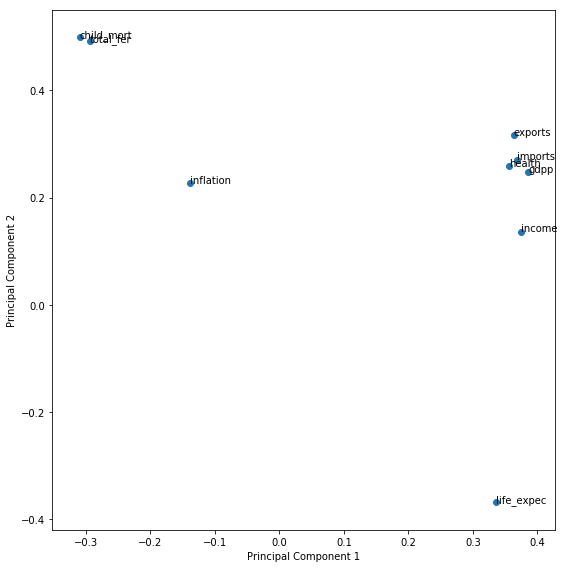

In [1581]:
# Let's plot them to visualise how these features are loaded
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [1582]:
# From the above plot we can observe that PC1 is high on import/export/income/GDPP were as PC2 is high on child_mort

In [1583]:
#Finally let's go ahead and do dimenstionality reduction using the two Principal Components
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=5)

In [1584]:
df_pca = pca_final.fit_transform(country2)
df_pca.shape

(164, 5)

In [1585]:
df_pca

array([[-2.77391894e+00,  1.38132942e+00, -5.37556910e-01,
         1.14374013e-01, -1.65130229e-01],
       [-1.11424658e-01, -1.57757670e+00, -4.76838613e-03,
        -5.28185450e-02, -5.06564086e-02],
       [-5.22347869e-01, -7.85661032e-01,  9.83090387e-01,
         1.08934646e-01, -2.81670242e-01],
       [-2.75016435e+00,  2.17016716e+00,  6.06597989e-01,
         1.52998277e-01, -2.52472095e-01],
       [ 8.38666022e-01, -9.69598318e-01, -2.42690128e-01,
        -1.82991400e-01, -1.13684236e-01],
       [ 2.03880467e-02, -7.31415313e-01,  1.48035504e+00,
         3.43315185e-01,  1.81631387e-02],
       [-4.55918156e-01, -1.44842836e+00,  1.86296223e-01,
        -1.24820383e-01, -1.70262901e-02],
       [ 3.75168061e+00,  3.41108558e-01, -1.51892392e-01,
         1.60503237e+00,  2.83818944e-01],
       [ 4.96412596e+00,  1.15723094e+00, -3.30712370e-01,
         1.50469211e-01, -1.24998922e-01],
       [-4.87696073e-01, -5.79878312e-01,  6.20735152e-01,
        -1.45225510e-01

In [1586]:
#Creating a transpose so that the each column is properly arranged
pc = np.transpose(df_pca)

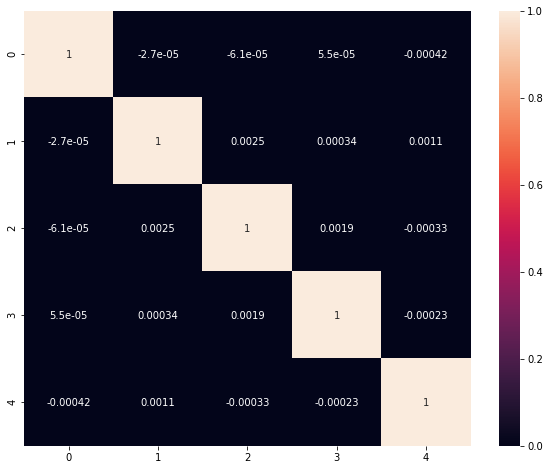

In [1587]:
#creating correlation matrix for the principal components to check that all the PCs are indenpendent of each other
corrmat = np.corrcoef(pc)
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (10,8))
sns.heatmap(corrmat,annot = True)

In [1588]:
pcs_df2 = pd.DataFrame({'PC1':pc[0],'PC2':pc[1],'PC3':pc[2],'PC4':pc[3],'PC5':pc[4]})

In [1589]:
pcs_df2.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.773919,1.381329,-0.537557,0.114374,-0.165130
1,-0.111425,-1.577577,-0.004768,-0.052819,-0.050656
2,-0.522348,-0.785661,0.983090,0.108935,-0.281670
3,-2.750164,2.170167,0.606598,0.152998,-0.252472
4,0.838666,-0.969598,-0.242690,-0.182991,-0.113684


In [1590]:
pcs_df2.shape

(164, 5)

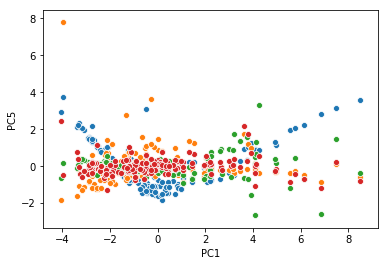

In [1591]:
#Visualising the points on the PCs.
# one of the prime advatanges of PCA is that you can visualise high dimensional data
sns.scatterplot(x='PC1',y='PC2',data=pcs_df2)
sns.scatterplot(x='PC1',y='PC3',data=pcs_df2)
sns.scatterplot(x='PC1',y='PC4',data=pcs_df2)
sns.scatterplot(x='PC1',y='PC5',data=pcs_df2)

In [1592]:
#Some distinct clusters are already visible to us.
#Let's go ahead and begin with the clustering process

# 2. K Means Clustering

In [1593]:
# Hopkins test examines whether data points differ significantly from uniformly distributed data 
# in the multidimensional space.

## 2.1 Hopkins statistic

In [1594]:
# Calculating the Hopkins statistic

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [1595]:
#Let's check the Hopkins measure
hopkins(pcs_df2)

0.8624587277553826

### Since the value is > 0.5 the given dataset has a good tendency to form clusters. We can go ahead with K mean clustering

### To find the optimum number of clusters, we use two techniques - the elbow curve method and the silhouette score method

## 2.2 silhouette analysis

In [1596]:
dat3_1 = pcs_df2

In [1597]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(dat3_1)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(dat3_1, cluster_labels)
    
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.5014833634365762
For n_clusters=3, the silhouette score is 0.4421504306787232
For n_clusters=4, the silhouette score is 0.43141509256076493
For n_clusters=5, the silhouette score is 0.43835039315430196
For n_clusters=6, the silhouette score is 0.34422113836503043
For n_clusters=7, the silhouette score is 0.3389629833229657
For n_clusters=8, the silhouette score is 0.32830933841852644


In [1598]:
## From the above analysis we find that 3 seems to be a good number of clusters for K means algorithm

## 2.3 Elbow curve method

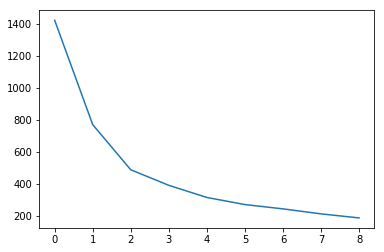

In [1599]:
# Now let's proceed to the elbow curve method
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(dat3_1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

### Here also we're seeing a distinct bend at around 3 clusters. Hence it seems a good K to choose.

In [1600]:
#Let's perform K means using K=3
model_clus3 = KMeans(n_clusters = 3, max_iter=50,random_state = 50)
model_clus3.fit(dat3_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=50, tol=0.0001, verbose=0)

In [1601]:
# Assign the cluster label to the dataset
dat4=pcs_df2
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus3.labels_)], axis=1)
dat_km.columns = ['PC1', 'PC2','PC3', 'PC4','PC5','ClusterID']
dat_km.head(10)

,PC1,PC2,PC3,PC4,PC5,ClusterID
0,-2.773919,1.381329,-0.537557,0.114374,-0.165130,0
1,-0.111425,-1.577577,-0.004768,-0.052819,-0.050656,1
2,-0.522348,-0.785661,0.983090,0.108935,-0.281670,1
3,-2.750164,2.170167,0.606598,0.152998,-0.252472,0
4,0.838666,-0.969598,-0.242690,-0.182991,-0.113684,1
5,0.020388,-0.731415,1.480355,0.343315,0.018163,1
6,-0.455918,-1.448428,0.186296,-0.124820,-0.017026,1
7,3.751681,0.341109,-0.151892,1.605032,0.283819,2
8,4.964126,1.157231,-0.330712,0.150469,-0.124999,2
9,-0.487696,-0.579878,0.620735,-0.145226,0.569874,1


In [1602]:
dat_km['ClusterID'].value_counts()

1    89
0    48
2    27
Name: ClusterID, dtype: int64

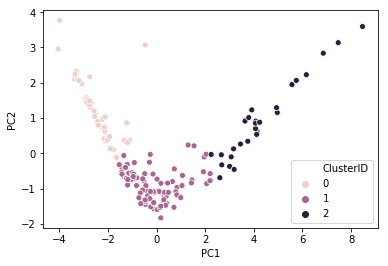

In [1603]:
sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

In [1604]:
# Merge the dataset with original data
Kmean_merged_df=pd.merge(country,dat_km, left_index=True,right_index=True)
Kmean_merged_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,PC5,ClusterID
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,-2.773919,1.381329,-0.537557,0.114374,-0.165130,0
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,-0.111425,-1.577577,-0.004768,-0.052819,-0.050656,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,-0.522348,-0.785661,0.983090,0.108935,-0.281670,1
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,-2.750164,2.170167,0.606598,0.152998,-0.252472,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0.838666,-0.969598,-0.242690,-0.182991,-0.113684,1


In [1605]:
# Drop the unnecessary columns
Kmean_merged_df.drop(['PC1','PC2','PC3','PC4','PC5'],axis=1, inplace = True)

In [1606]:
Kmean_merged_df.shape

(161, 11)

In [1607]:
# Check the no. of countries in each cluster
Kmean_merged_df['ClusterID'].value_counts()

1    87
0    47
2    27
Name: ClusterID, dtype: int64

# 2.4 Analysis and Visualisation of the clusters formed using Kmean Clustering

In [1608]:
# Sort the data in increasing order of GDP
Kmean_merged_df = Kmean_merged_df.sort_values(by = "gdpp", ascending = True)

In [1609]:
Kmean_merged_df[ Kmean_merged_df['ClusterID'] == 0].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
26,Burundi,93.6,20.61,26.80,90.55,764,12.30,57.7,6.26,231,0
88,Liberia,89.3,62.46,38.59,302.80,700,5.47,60.8,5.02,327,0
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.80,57.5,6.54,334,0
112,Niger,123.0,77.26,17.96,170.87,814,2.55,58.8,7.49,348,0
93,Madagascar,62.2,103.25,15.57,177.59,1390,8.79,60.8,4.60,413,0


In [1610]:
Kmean_merged_df[ Kmean_merged_df['ClusterID'] == 1].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
106,Mozambique,101.0,131.99,21.83,193.58,918,7.64,54.5,5.56,419,1
94,Malawi,90.5,104.65,30.25,160.19,1030,12.10,53.1,5.31,459,1
150,Togo,90.3,196.18,37.33,279.62,1210,1.18,58.7,4.87,488,1
126,Rwanda,63.6,67.56,59.12,168.90,1350,2.61,64.6,4.51,563,1
12,Bangladesh,49.4,121.28,26.68,165.24,2440,7.14,70.4,2.33,758,1


In [1611]:
Kmean_merged_df[ Kmean_merged_df['ClusterID'] == 2].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,2
109,Nepal,47.0,56.71,31.08,215.49,1990,15.10,68.3,2.61,592,2
155,Uganda,81.0,101.74,53.61,170.17,1540,10.60,56.8,6.15,595,2
97,Mali,137.0,161.42,35.26,248.51,1870,4.37,59.5,6.55,708,2
136,Solomon Islands,28.1,635.97,110.30,1047.48,1780,6.81,61.7,4.24,1290,2


### mean of GDPP , Child Mort and income,health,exports,imports,life_expec grouped by cluster id

In [1612]:
# Lets find the mean of GDPP , Child Mort and income,health,exports,imports,life_expec

clu_gdpp = pd.DataFrame(Kmean_merged_df.groupby(["ClusterID"]).gdpp.mean().round(2))
clu_child_mort = pd.DataFrame(Kmean_merged_df.groupby(["ClusterID"]).child_mort.mean().round(2))
clu_income = pd.DataFrame(Kmean_merged_df.groupby(["ClusterID"]).income.mean().round(2))

clu_health = pd.DataFrame(Kmean_merged_df.groupby(["ClusterID"]).health.mean().round(2))
clu_exports = pd.DataFrame(Kmean_merged_df.groupby(["ClusterID"]).exports.mean().round(2))
clu_imports = pd.DataFrame(Kmean_merged_df.groupby(["ClusterID"]).imports.mean().round(2))
clu_life_expec = pd.DataFrame(Kmean_merged_df.groupby(["ClusterID"]).life_expec.mean().round(2))

# Combine all the individual dataset 
df = pd.concat([clu_gdpp,clu_child_mort,clu_income,clu_health,clu_exports,clu_imports,clu_life_expec], axis=1)
df.columns = ["gdpp","child_mort","income","health","exports","imports","life_expec"]
df

,gdpp,child_mort,income,health,exports,imports,life_expec
ClusterID,,,,,,,
0,6132.49,67.77,9238.40,462.85,3279.67,3047.91,64.36
1,10300.84,25.19,15339.17,846.44,4554.43,4489.45,72.58
2,27949.41,31.00,29385.19,2576.30,13564.46,11761.24,74.33


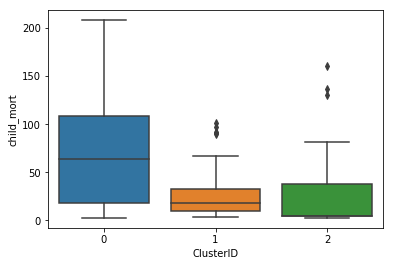

In [1613]:
# plots
sns.boxplot(x='ClusterID', y='child_mort', data=Kmean_merged_df)

# Cluster 0 has High Child Mort

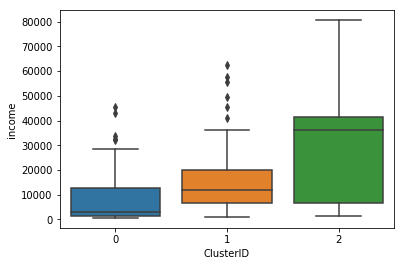

In [1614]:
# plots
sns.boxplot(x='ClusterID', y='income', data=Kmean_merged_df)

# Cluster 2 has High Income

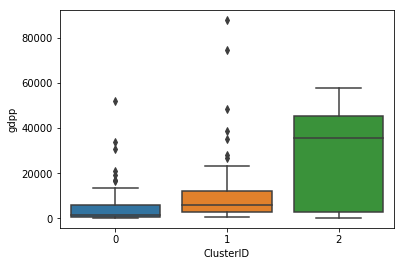

In [1615]:
# plots
sns.boxplot(x='ClusterID', y='gdpp', data=Kmean_merged_df)

# Cluster 2 has High gdpp

In [1616]:
# To find the list of countries which are in diar need of help based on GDPP child mort and income
# Here's how we can make up for the outlier analysis that we did earlier.
# So we can choose those cluster means as cut offs and find the final list of countries from the original dataset. it will
# include those countries which has been removed as part of outlier analysis.

In [1617]:
#Let's use the concept of binning, Find the countries which has  avg income and GDP less then the cluster 0 Average.

final_list=country[country['gdpp']<=6132.49]  # Avg GDPP of cluster 0
final_list=final_list[final_list['income']<= 9238.40] # Avg income of cluster 0
final_list=final_list[final_list['child_mort']>= 67.77] # Avg child_mort of cluster 0
final_list.shape

(32, 10)

In [1618]:
# We have got 32 countries and need to select 5 countries which are is real need of help. 
# lets find the average of gdpp/income/child_mort for the available dataset final_list and 
# get the list of countries which has below avarge GDPP and income and above average child_mort

final_list_1 = final_list[(final_list['gdpp'] < final_list.gdpp.mean()) & (final_list['income'] < final_list.income.mean()) & (final_list['child_mort'] > final_list.child_mort.mean()) ]
final_list_1.shape  # got the list of 10 underdeveloped countries
final_list_1


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
17,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758
25,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.010,47.5,5.21,446
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.800,57.5,6.54,334
63,Guinea,109.0,196.34,31.95,279.94,1190,16.100,58.0,5.34,648
64,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.970,55.6,5.05,547
66,Haiti,208.0,101.29,45.74,428.31,1500,5.450,32.1,3.33,662
97,Mali,137.0,161.42,35.26,248.51,1870,4.370,59.5,6.55,708
112,Niger,123.0,77.26,17.96,170.87,814,2.550,58.8,7.49,348
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.200,55.0,5.20,399


In [1619]:
# Sort the data in increasing order of GDP
final_list_1 = final_list_1.sort_values(by = "gdpp", ascending = True)
final_list_1

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.800,57.5,6.54,334
112,Niger,123.0,77.26,17.96,170.87,814,2.550,58.8,7.49,348
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.200,55.0,5.20,399
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.010,47.5,5.21,446
64,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.970,55.6,5.05,547
25,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575
63,Guinea,109.0,196.34,31.95,279.94,1190,16.100,58.0,5.34,648
66,Haiti,208.0,101.29,45.74,428.31,1500,5.450,32.1,3.33,662
97,Mali,137.0,161.42,35.26,248.51,1870,4.370,59.5,6.55,708
17,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758


In [1620]:
final_list_1 = final_list_1.sort_values(by = "child_mort", ascending = False)
final_list_1

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
66,Haiti,208.0,101.29,45.74,428.31,1500,5.450,32.1,3.33,662
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.200,55.0,5.20,399
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.010,47.5,5.21,446
97,Mali,137.0,161.42,35.26,248.51,1870,4.370,59.5,6.55,708
112,Niger,123.0,77.26,17.96,170.87,814,2.550,58.8,7.49,348
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.800,57.5,6.54,334
25,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575
64,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.970,55.6,5.05,547
17,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758
63,Guinea,109.0,196.34,31.95,279.94,1190,16.100,58.0,5.34,648


In [1621]:
final_list_1 = final_list_1.sort_values(by = "income", ascending = True)
final_list_1

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.800,57.5,6.54,334
112,Niger,123.0,77.26,17.96,170.87,814,2.550,58.8,7.49,348
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.010,47.5,5.21,446
63,Guinea,109.0,196.34,31.95,279.94,1190,16.100,58.0,5.34,648
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.200,55.0,5.20,399
64,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.970,55.6,5.05,547
25,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575
66,Haiti,208.0,101.29,45.74,428.31,1500,5.450,32.1,3.33,662
17,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758
97,Mali,137.0,161.42,35.26,248.51,1870,4.370,59.5,6.55,708


# 2.5
## Analysis Summary: 

- Cluster 0 - Underdeveloped countries:- Low GDPP,Low Income, Low ratio of Import and export, Less Expenditure on health Hence low Life expectancy and High Child Mort rate 
- Cluster 1 - Developing countries :- Avarage GDPP, Average ratio of Import and export, Avg. Expenditure on health Hence good Life expectancy and Avg Child Mort rate
- Cluster 2 - Developed Countries:-  High GDPP,High Income, High ratio of Import and export, High Expenditure on health Hence High Life expectancy and low Child Mort rate 

## List of the countries which are in diar need of Help GDPP/Income and Child_mort  is as below
- Congo, Dem. Rep.
- Niger
- Sierra Leone
- Central African Republic
- Guinea-Bissau
- Guinea
- Haiti
- Burkina Faso
- Mali
- Benin


## 3. Hierarchical Clustering

In [1622]:
dat5_0 = pcs_df2

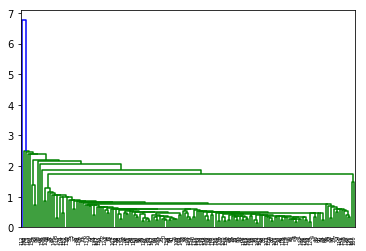

In [1623]:
# single linkage
mergings = linkage(dat5_0, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

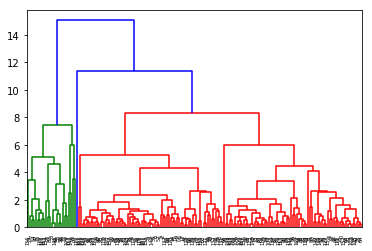

In [1624]:
# complete linkage
dat5_1 = pcs_df2
mergings = linkage(dat5_1, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [1625]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [1626]:
# Assign the cluster label to the dataset
dat6=pcs_df2
dat6.index = pd.RangeIndex(len(dat6.index))
dat_HCL = pd.concat([dat6, pd.Series(cluster_labels)], axis=1)
dat_HCL.columns = ['PC1', 'PC2','PC3', 'PC4','PC5','cluster_labels']
dat_HCL.head(10)

,PC1,PC2,PC3,PC4,PC5,cluster_labels
0,-2.773919,1.381329,-0.537557,0.114374,-0.165130,0
1,-0.111425,-1.577577,-0.004768,-0.052819,-0.050656,0
2,-0.522348,-0.785661,0.983090,0.108935,-0.281670,0
3,-2.750164,2.170167,0.606598,0.152998,-0.252472,0
4,0.838666,-0.969598,-0.242690,-0.182991,-0.113684,0
5,0.020388,-0.731415,1.480355,0.343315,0.018163,0
6,-0.455918,-1.448428,0.186296,-0.124820,-0.017026,0
7,3.751681,0.341109,-0.151892,1.605032,0.283819,1
8,4.964126,1.157231,-0.330712,0.150469,-0.124999,1
9,-0.487696,-0.579878,0.620735,-0.145226,0.569874,0


In [1627]:
# Check the no. of countries in each cluster
dat_HCL['cluster_labels'].value_counts()

0    139
1     24
2      1
Name: cluster_labels, dtype: int64

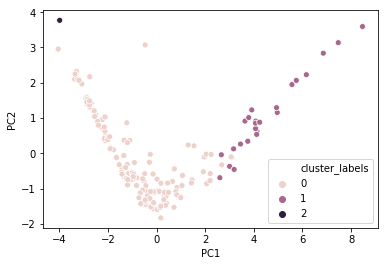

In [1628]:
sns.scatterplot(x='PC1',y='PC2',hue='cluster_labels',legend='full',data=dat_HCL)

In [1629]:
# Merge the dataset with original data
HCL_merged_df=pd.merge(country,dat_HCL, left_index=True,right_index=True)
HCL_merged_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,PC5,cluster_labels
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,-2.773919,1.381329,-0.537557,0.114374,-0.165130,0
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,-0.111425,-1.577577,-0.004768,-0.052819,-0.050656,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,-0.522348,-0.785661,0.983090,0.108935,-0.281670,0
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,-2.750164,2.170167,0.606598,0.152998,-0.252472,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0.838666,-0.969598,-0.242690,-0.182991,-0.113684,0


In [1630]:
HCL_merged_df.shape

(161, 16)

In [1631]:
HCL_merged_df.drop(['PC1','PC2','PC3','PC4','PC5'],axis=1, inplace = True)

In [1632]:
HCL_merged_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0


# 3.1 Analysis and Visualisation of the clusters formed using Hierarchical Clustering

In [1633]:
# Sort the data in increasing order of GDP
HCL_merged_df = HCL_merged_df.sort_values(by = "gdpp", ascending = True)

In [1634]:
HCL_merged_df[ HCL_merged_df['cluster_labels'] == 0].head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
26,Burundi,93.6,20.61,26.80,90.55,764,12.30,57.7,6.26,231,0
88,Liberia,89.3,62.46,38.59,302.80,700,5.47,60.8,5.02,327,0
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.80,57.5,6.54,334,0
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,0
93,Madagascar,62.2,103.25,15.57,177.59,1390,8.79,60.8,4.60,413,0
106,Mozambique,101.0,131.99,21.83,193.58,918,7.64,54.5,5.56,419,0
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.01,47.5,5.21,446,0
94,Malawi,90.5,104.65,30.25,160.19,1030,12.10,53.1,5.31,459,0
50,Eritrea,55.2,23.09,12.82,112.31,1420,11.60,61.7,4.61,482,0
150,Togo,90.3,196.18,37.33,279.62,1210,1.18,58.7,4.87,488,0


In [1635]:
HCL_merged_df[ HCL_merged_df['cluster_labels'] == 1].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
109,Nepal,47.0,56.71,31.08,215.49,1990,15.10,68.3,2.61,592,1
155,Uganda,81.0,101.74,53.61,170.17,1540,10.60,56.8,6.15,595,1
97,Mali,137.0,161.42,35.26,248.51,1870,4.37,59.5,6.55,708,1
136,Solomon Islands,28.1,635.97,110.30,1047.48,1780,6.81,61.7,4.24,1290,1
142,Sudan,76.7,291.56,93.54,254.56,3370,19.60,66.3,4.88,1480,1


In [1636]:
HCL_merged_df[ HCL_merged_df['cluster_labels'] == 2].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
112,Niger,123.0,77.26,17.96,170.87,814,2.55,58.8,7.49,348,2


### mean of GDPP , Child Mort and income,health,exports,imports,life_expec grouped by cluster id

In [1637]:
# Lets find the mean of GDPP , Child Mort and income,health,exports,imports,life_expec

clu_gdpp = pd.DataFrame(HCL_merged_df.groupby(["cluster_labels"]).gdpp.mean().round(2))
clu_child_mort = pd.DataFrame(HCL_merged_df.groupby(["cluster_labels"]).child_mort.mean().round(2))
clu_income = pd.DataFrame(HCL_merged_df.groupby(["cluster_labels"]).income.mean().round(2))

clu_health = pd.DataFrame(HCL_merged_df.groupby(["cluster_labels"]).health.mean().round(2))
clu_exports = pd.DataFrame(HCL_merged_df.groupby(["cluster_labels"]).exports.mean().round(2))
clu_imports = pd.DataFrame(HCL_merged_df.groupby(["cluster_labels"]).imports.mean().round(2))
clu_life_expec = pd.DataFrame(HCL_merged_df.groupby(["cluster_labels"]).life_expec.mean().round(2))

# Combine all the individual dataset 
df = pd.concat([clu_gdpp,clu_child_mort,clu_income,clu_health,clu_exports,clu_imports,clu_life_expec], axis=1)
df.columns = ["gdpp","child_mort","income","health","exports","imports","life_expec"]
df

,gdpp,child_mort,income,health,exports,imports,life_expec
cluster_labels,,,,,,,
0,9160.67,39.87,13475.14,732.37,4239.27,4129.25,69.83
1,28868.12,27.86,30361.67,2722.26,14166.74,12068.26,74.61
2,348.00,123.00,814.00,17.96,77.26,170.87,58.80


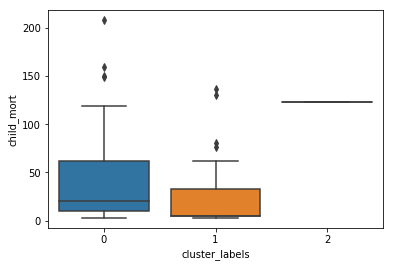

In [1638]:
# plots
sns.boxplot(x='cluster_labels', y='child_mort', data=HCL_merged_df)

# Cluster 0 has High Child Mort

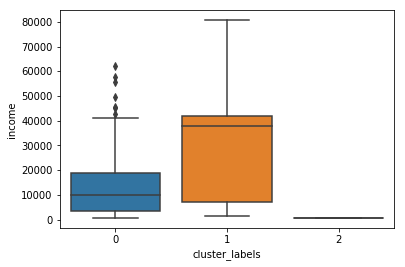

In [1639]:
# plots
sns.boxplot(x='cluster_labels', y='income', data=HCL_merged_df)

# Cluster 1 has High Income

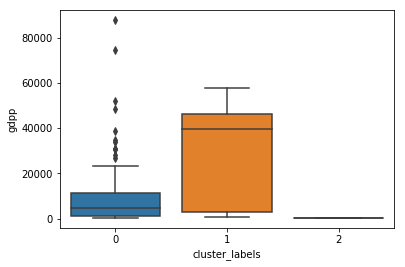

In [1640]:
# plots
sns.boxplot(x='cluster_labels', y='gdpp', data=HCL_merged_df)

# Cluster 1 has High gdpp

In [1641]:
# To find the list of countries which are in diar need of help based on GDPP child mort and income
# Here's how we can make up for the outlier analysis that we did earlier.
# So we can choose those cluster means as cut offs and find the final list of countries from the original dataset. it will
# include those countries which has been removed as part of outlier analysis.

In [1642]:
#Let's use the concept of binning, Find the countries which has  avg income and GDP less then the cluster 0 Average.
final_list1=country[country['gdpp']<=9160.67]  # Avg GDPP of cluster 0
final_list1=final_list1[final_list1['income']<= 13475.14] # Avg income of cluster 0
final_list1=final_list1[final_list1['child_mort']>= 39.87] # Avg income of cluster 0
final_list1.shape

(54, 10)

In [1643]:
# We have got 54 countries and need to select 5 countries which are is real need of help. 
# lets find the average of gdpp/income/child_mort for the available dataset final_list1 and 
# get the list of countries which has below avarge GDPP and income and above average child_mort

final_list_2 = final_list1[(final_list1['gdpp'] < final_list1.gdpp.mean()) & 
                           (final_list1['income'] < final_list1.income.mean()) &
                           (final_list1['child_mort'] > final_list1.child_mort.mean())]
final_list_2.shape  # got the list of 21 underdeveloped countries
final_list_2

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.440,56.2,5.82,553
17,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758
25,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575
26,Burundi,93.6,20.61,26.80,90.55,764,12.300,57.7,6.26,231
28,Cameroon,108.0,290.82,67.20,353.70,2660,1.910,57.3,5.11,1310
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.010,47.5,5.21,446
32,Chad,150.0,330.10,40.63,390.20,1930,6.390,56.5,6.59,897
36,Comoros,88.2,126.88,34.68,397.57,1410,3.870,65.9,4.75,769
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.800,57.5,6.54,334
40,Cote d'Ivoire,111.0,617.32,64.66,528.26,2690,5.390,56.3,5.27,1220


In [1644]:
final_list_2 = final_list_2.sort_values(by = "gdpp", ascending = True)
final_list_2


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,20.61,26.80,90.55,764,12.300,57.7,6.26,231
88,Liberia,89.3,62.46,38.59,302.80,700,5.470,60.8,5.02,327
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.800,57.5,6.54,334
112,Niger,123.0,77.26,17.96,170.87,814,2.550,58.8,7.49,348
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.200,55.0,5.20,399
106,Mozambique,101.0,131.99,21.83,193.58,918,7.640,54.5,5.56,419
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.010,47.5,5.21,446
94,Malawi,90.5,104.65,30.25,160.19,1030,12.100,53.1,5.31,459
150,Togo,90.3,196.18,37.33,279.62,1210,1.180,58.7,4.87,488
64,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.970,55.6,5.05,547


In [1645]:
final_list_2 = final_list_2.sort_values(by = "child_mort", ascending = False)
final_list_2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
66,Haiti,208.0,101.29,45.74,428.31,1500,5.45,32.1,3.33,662
132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399
32,Chad,150.0,330.10,40.63,390.20,1930,6.39,56.5,6.59,897
31,Central African Republic,149.0,52.63,17.75,118.19,888,2.01,47.5,5.21,446
97,Mali,137.0,161.42,35.26,248.51,1870,4.37,59.5,6.55,708


# 3.2
## Analysis Summary: 

- Cluster 0 - Developing countries:- Avarage GDPP, Average ratio of Import and export, Avg. Expenditure on health Hence good Life expectancy and Avg Child Mort rate
- Cluster 1 - Developed countries :- High GDPP,High Income, High ratio of Import and export, High Expenditure on health Hence High Life expectancy and low Child Mort rate 
- Cluster 2 - Underdeveloped Countries:-  Low GDPP,Low Income, Low ratio of Import and export, Less Expenditure on health Hence low Life expectancy and High Child Mort rate 


## List of the countries which are in diar need of Help based on GDPP/Income and Child_mort is as below
- Burundi
- Liberia 
- Congo,Dem. Rep. 
- Niger 
- Sierra Leone
- Mozambique 
- Central African Republic 
- Malawi 
- Togo 
- Guinea-Bissau 
- Afghanistan 
- Burkina Faso 
- Guinea 
- Haiti 
- Mali 
- Benin
- Comoros 
- Chad 
- Lesotho 
- Cote d'Ivoire 
- Cameroon


# Final Summary: From the above 2 clustering methods , below are the 5 countries(common countries among the list of top 10 in the increasing order of GDP) which are in diar need of help
    
- Congo, Dem. Rep.	
- Niger
- Sierra Leone
- Central African Republic
- Guinea-Bissau